# Image Denoising using Convolutional Autoencoders - Prahalad M (23011101096)

## Introduction
The objective of this lab is to design, train, and evaluate **Convolutional Autoencoder (CAE)** architectures for **image denoising** tasks using two different datasets — **MNIST** and **CIFAR-10**.  
Autoencoders are neural network models designed to learn efficient data representations in an unsupervised manner. In the context of image processing, **denoising autoencoders** learn to reconstruct clean images from their noisy versions by encoding key image features into a low-dimensional latent representation (bottleneck) and decoding them back into the original form.

The project involves two separate but conceptually similar CNN-based architectures:
1. **Model 1:** Denoising autoencoder for grayscale MNIST digits  
2. **Model 2:** Denoising autoencoder for colored CIFAR-10 images  

Both models are compared in terms of design, learning objectives, and performance metrics.



## Model 1 – MNIST Denoising Autoencoder

### Data Preprocessing
- The **MNIST** dataset (28×28 grayscale handwritten digits) was normalized to the [0, 1] range for stable convergence.  
- Gaussian noise (mean = 0, std = 0.5) was added to simulate corrupted inputs.  
- Both noisy and clean images were reshaped to `(batch, 28, 28, 1)` before being fed into the network.


In [ ]:
# 1. IMPORT LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import cv2

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [ ]:
# 2. LOAD AND PREPROCESS DATA
# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape for CNN (add channel dimension)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


In [ ]:
# 3. ADD NOISE TO IMAGES
def add_gaussian_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=images.shape
    )
    noisy_images = np.clip(noisy_images, 0.0, 1.0)
    return noisy_images

# Create noisy versions
noise_factor = 0.5
x_train_noisy = add_gaussian_noise(x_train, noise_factor)
x_test_noisy = add_gaussian_noise(x_test, noise_factor)

print("Noisy images created successfully!")


Noisy images created successfully!


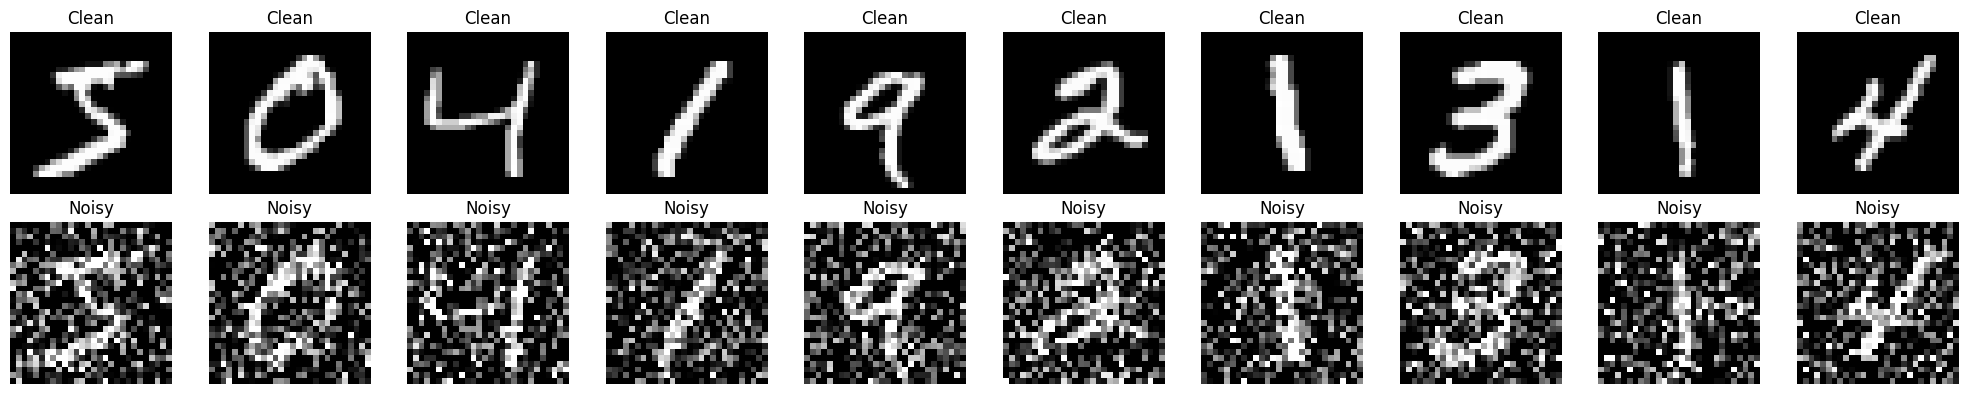

In [ ]:
# 4. VISUALIZE NOISY IMAGES
def visualize_samples(clean, noisy, n=10):
    """Visualize clean vs noisy images"""
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(clean[i].reshape(28, 28), cmap='gray')
        plt.title("Clean")
        plt.axis('off')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(noisy[i].reshape(28, 28), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(x_train, x_train_noisy, n=10)


### Model Architecture
- Implemented as a **convolutional autoencoder** with symmetrical encoder–decoder blocks.  
- **Encoder:** Three Conv2D layers (32 → 64 → 128 filters) with ReLU activation and MaxPooling for down-sampling.  
- **Latent Space:** Compact feature map capturing essential digit patterns.  
- **Decoder:** UpSampling + Conv2DTranspose layers mirroring the encoder to reconstruct clean images.  
- **Output:** Sigmoid activation for pixel values in [0, 1]. Optimized with **Adam** and **MSE loss**.


In [ ]:
# 5. BUILD CONVOLUTIONAL AUTOENCODER
def build_autoencoder(input_shape=(28, 28, 1)):
    """
    Build a Convolutional Autoencoder with Batch Normalization
    """
    input_img = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.BatchNormalization()(x)

    # Decoder
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded, name='Denoising_Autoencoder')
    return autoencoder

autoencoder = build_autoencoder()
autoencoder.summary()


Model: "Denoising_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,593 (1.28 MB)

 Trainable params: 333,697 (1.27 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# 6. COMPILE AND TRAIN MODEL
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['mae']
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1
)

print("\n" + "="*50)
print("TRAINING STARTED")
print("="*50 + "\n")

history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=10,
    batch_size=512,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\n" + "="*10)
print("TRAINING COMPLETED")
print("="*10 + "\n")



TRAINING STARTED

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 27s 120ms/step - loss: 0.3395 - mae: 0.1975 - val_loss: 0.3610 - val_mae: 0.2374 - learning_rate: 0.0010
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.1072 - mae: 0.0458 - val_loss: 0.3425 - val_mae: 0.1854 - learning_rate: 0.0010
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0989 - mae: 0.0386 - val_loss: 0.2324 - val_mae: 0.1139 - learning_rate: 0.0010
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0960 - mae: 0.0363 - val_loss: 0.1287 - val_mae: 0.0555 - learning_rate: 0.0010
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0944 - mae: 0.0351 - val_loss: 0.1010 - val_mae: 0.0392 - learning_rate: 0.0010
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0933 - mae: 0.0343 - val_loss: 0.0931 - val_mae: 0.0347 - learning_rate: 0.0010
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0926 - mae: 0.0338 - val_loss: 0.0929 - val_mae: 0.0337 - 

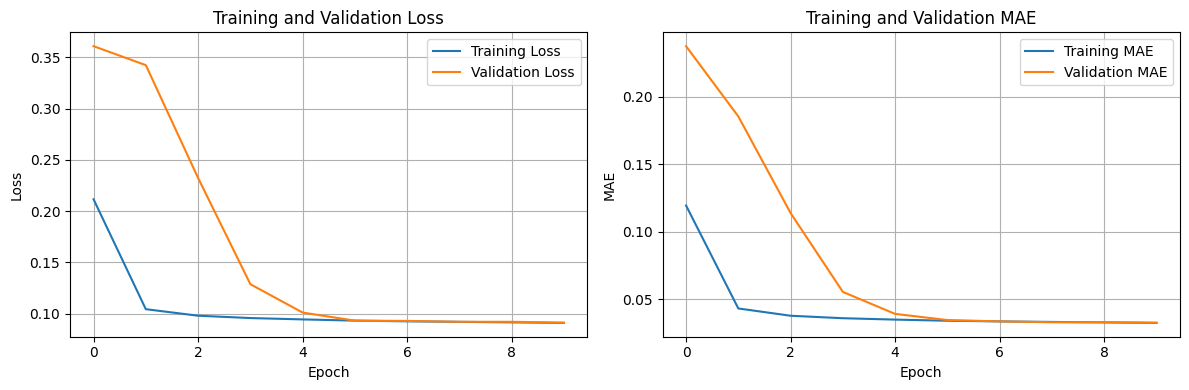

In [ ]:
# 7. PLOT TRAINING HISTORY
def plot_history(history):
    """Plot training and validation loss"""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('Training and Validation MAE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_history(history)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


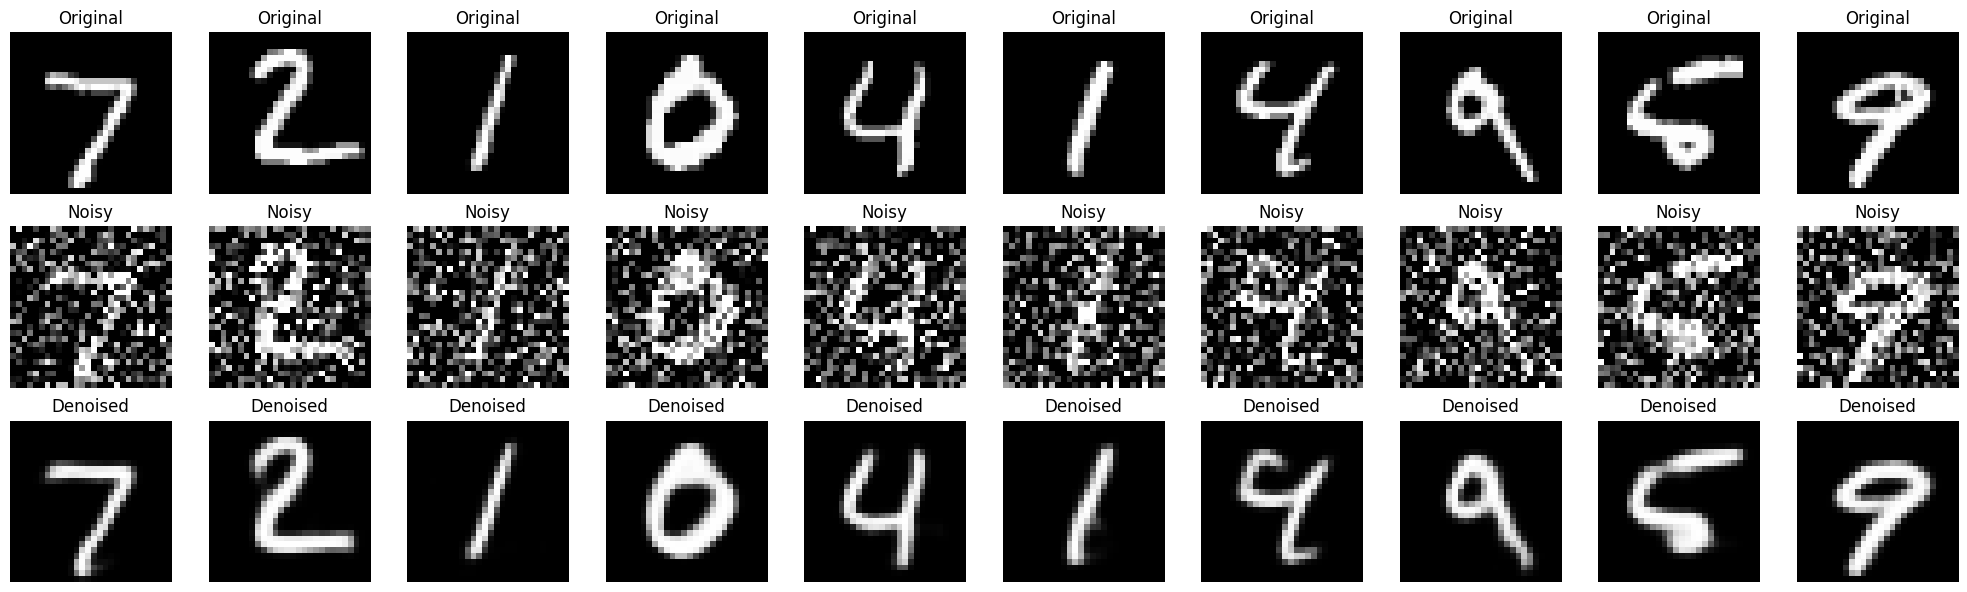

In [ ]:
# 8. EVALUATE MODEL - DENOISED OUTPUTS
denoised_images = autoencoder.predict(x_test_noisy)

def visualize_results(clean, noisy, denoised, n=10):
    """Visualize clean, noisy, and denoised images"""
    plt.figure(figsize=(20, 6))
    for i in range(n):
        plt.subplot(3, n, i + 1)
        plt.imshow(clean[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy[i].reshape(28, 28), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(denoised[i].reshape(28, 28), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_results(x_test, x_test_noisy, denoised_images, n=10)


In [ ]:
# 9. QUANTITATIVE EVALUATION - PSNR AND SSIM
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def calculate_metrics(clean, denoised):
    psnr_values, ssim_values = [], []
    for i in range(len(clean)):
        psnr_val = psnr(clean[i], denoised[i], data_range=1.0)
        ssim_val = ssim(clean[i].reshape(28, 28),
                        denoised[i].reshape(28, 28),
                        data_range=1.0)
        psnr_values.append(psnr_val)
        ssim_values.append(ssim_val)
    return np.array(psnr_values), np.array(ssim_values)

psnr_noisy, ssim_noisy = calculate_metrics(x_test, x_test_noisy)
psnr_denoised, ssim_denoised = calculate_metrics(x_test, denoised_images)

print("\n" + "="*60)
print("QUANTITATIVE EVALUATION RESULTS")
print("="*60)
print(f"\nNoisy Images:\n  Average PSNR: {np.mean(psnr_noisy):.2f} dB")
print(f"  Average SSIM: {np.mean(ssim_noisy):.4f}")
print(f"\nDenoised Images:\n  Average PSNR: {np.mean(psnr_denoised):.2f} dB")
print(f"  Average SSIM: {np.mean(ssim_denoised):.4f}")
print(f"\nImprovement:\n  PSNR Gain: {np.mean(psnr_denoised)-np.mean(psnr_noisy):.2f} dB")
print(f"  SSIM Gain: {np.mean(ssim_denoised)-np.mean(ssim_noisy):.4f}")
print("="*60 + "\n")



QUANTITATIVE EVALUATION RESULTS

Noisy Images:
  Average PSNR: 9.38 dB
  Average SSIM: 0.3750

Denoised Images:
  Average PSNR: 20.57 dB
  Average SSIM: 0.8842

Improvement:
  PSNR Gain: 11.19 dB
  SSIM Gain: 0.5091



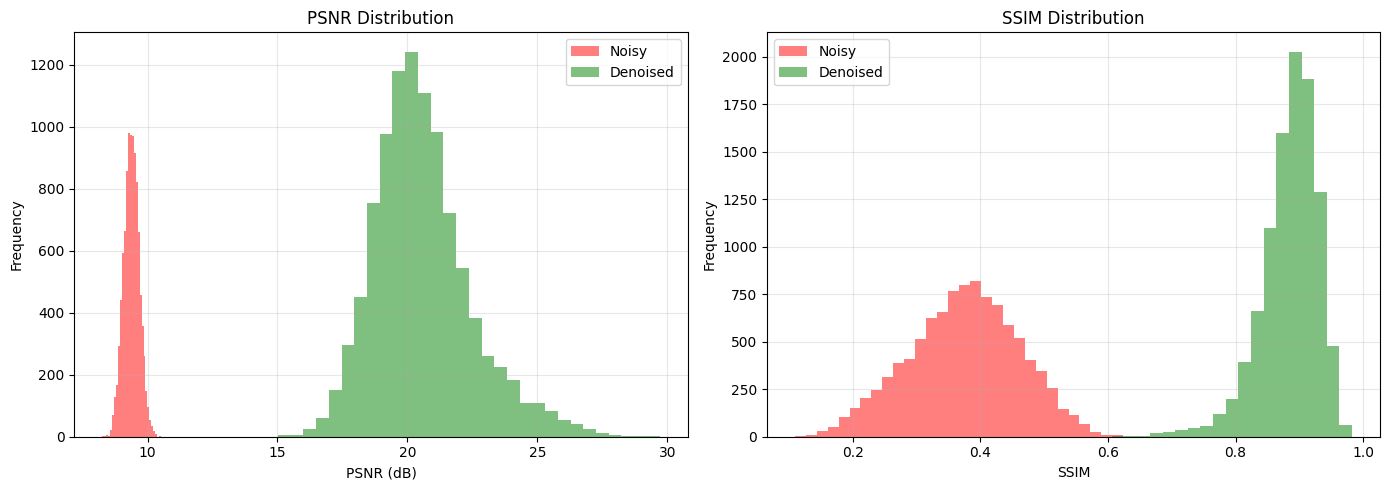

In [ ]:
# 10. PLOT METRICS DISTRIBUTION
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(psnr_noisy, bins=30, alpha=0.5, label='Noisy', color='red')
plt.hist(psnr_denoised, bins=30, alpha=0.5, label='Denoised', color='green')
plt.xlabel('PSNR (dB)')
plt.ylabel('Frequency')
plt.title('PSNR Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(ssim_noisy, bins=30, alpha=0.5, label='Noisy', color='red')
plt.hist(ssim_denoised, bins=30, alpha=0.5, label='Denoised', color='green')
plt.xlabel('SSIM')
plt.ylabel('Frequency')
plt.title('SSIM Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# 11. SAVE MODEL
autoencoder.save('denoising_autoencoder_mnist.h5')
print("Model saved as 'denoising_autoencoder_mnist.h5'")


Model saved as 'denoising_autoencoder_mnist.h5'


## Model 2 – CIFAR-10 Denoising Autoencoder

### Data Preprocessing
- The **CIFAR-10** dataset (32×32 RGB images across 10 classes) was scaled to [0, 1].  
- Gaussian noise (mean = 0, std = 0.3) was added to produce noisy inputs.  
- Images were stored as tensors of shape `(batch, 32, 32, 3)` to retain color channels.


In [ ]:
# 1. IMPORT LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

print("TensorFlow version:", tf.__version__)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


TensorFlow version: 2.19.0


In [ ]:
# 2. LOAD AND PREPROCESS DATA
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Image shape: {x_train[0].shape}")

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
Image shape: (32, 32, 3)


In [ ]:
# 3. ADD NOISE TO IMAGES
def add_gaussian_noise(images, noise_factor=0.3):
    """Add Gaussian noise to images"""
    noisy_images = images + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=images.shape
    )
    noisy_images = np.clip(noisy_images, 0.0, 1.0)
    return noisy_images

noise_factor = 0.3
x_train_noisy = add_gaussian_noise(x_train, noise_factor)
x_test_noisy = add_gaussian_noise(x_test, noise_factor)

print("Noisy images created successfully!")


Noisy images created successfully!


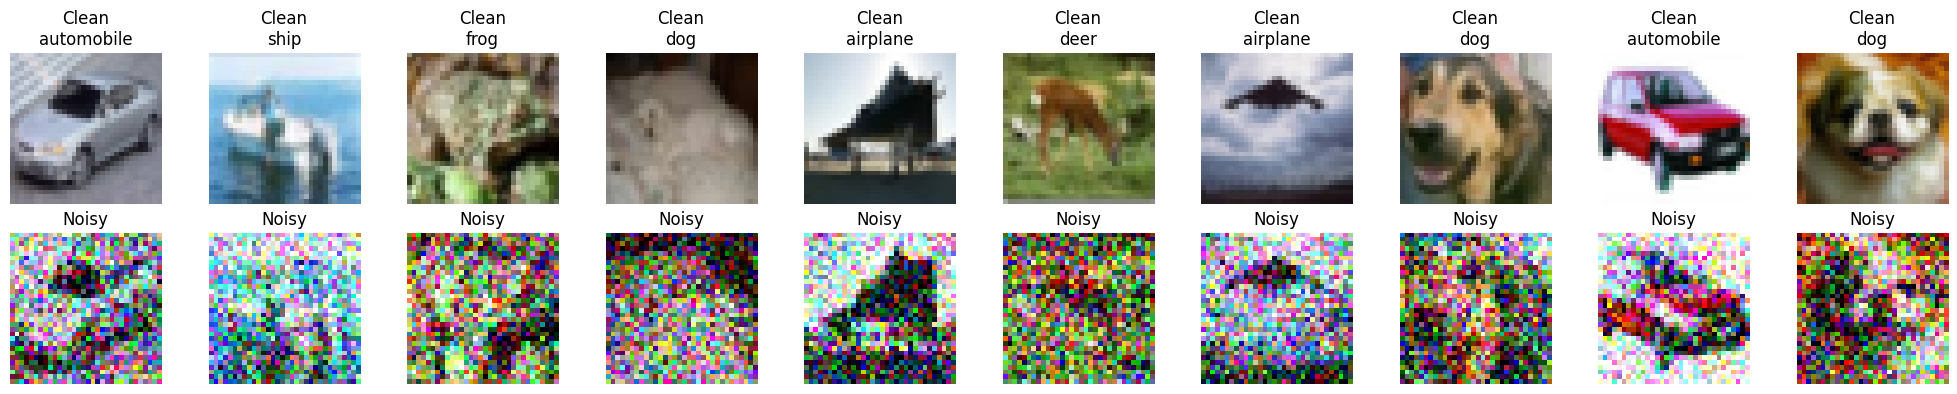

In [ ]:
# 4. VISUALIZE NOISY IMAGES
def visualize_samples(clean, noisy, labels, n=10):
    plt.figure(figsize=(20, 4))
    indices = np.random.choice(len(clean), n, replace=False)

    for i, idx in enumerate(indices):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(clean[idx])
        plt.title(f"Clean\n{class_names[labels[idx][0]]}")
        plt.axis('off')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(noisy[idx])
        plt.title("Noisy")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(x_train, x_train_noisy, y_train, n=10)


### Model Architecture
- Based on the same convolutional autoencoder principle as Model 1 but adapted for RGB data.  
- **Encoder:** Conv2D layers (64 → 128 → 256 filters) with Batch Normalization and ReLU activations for stability.  
- **Latent Layer:** Compressed multi-channel representation encoding spatial and color features.  
- **Decoder:** Conv2DTranspose + UpSampling layers mirroring the encoder to restore RGB images.  
- **Output:** Sigmoid activation with **MSE loss** and **Adam** optimizer, consistent with Model 1.


In [ ]:
# 5. BUILD DEEPER CONVOLUTIONAL AUTOENCODER FOR CIFAR-10
from tensorflow.keras import backend as K
K.clear_session()
def build_autoencoder(input_shape=(32, 32, 3)):
    input_img = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    encoded = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.BatchNormalization()(encoded)

    # Decoder
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = models.Model(input_img, decoded, name='CIFAR10_Denoising_Autoencoder')
    return autoencoder

autoencoder = build_autoencoder()
autoencoder.summary()


Model: "CIFAR10_Denoising_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 128)    │       295,04

 Total params: 2,887,811 (11.02 MB)

 Trainable params: 2,884,227 (11.00 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [ ]:
# 6. COMPILE AND TRAIN MODEL
# Compile model
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['mae']
)

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

print("\n" + "="*50)
print("TRAINING STARTED")
print("="*50 + "\n")

# Train the model
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=10,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\n" + "="*50)
print("TRAINING COMPLETED")
print("="*50 + "\n")



TRAINING STARTED

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 68s 236ms/step - loss: 0.6068 - mae: 0.1073 - val_loss: 0.6367 - val_mae: 0.1569 - learning_rate: 0.0010
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 31s 159ms/step - loss: 0.5680 - mae: 0.0666 - val_loss: 0.5849 - val_mae: 0.0940 - learning_rate: 0.0010
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - loss: 0.5657 - mae: 0.0628 - val_loss: 0.5745 - val_mae: 0.0736 - learning_rate: 0.0010
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 31s 159ms/step - loss: 0.5646 - mae: 0.0610 - val_loss: 0.5766 - val_mae: 0.0732 - learning_rate: 0.0010
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 31s 156ms/step - loss: 0.5639 - mae: 0.0598 - val_loss: 0.5735 - val_mae: 0.0685 - learning_rate: 0.0010
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 31s 158ms/step - loss: 0.5634 - mae: 0.0589 - val_loss: 0.5699 - val_mae: 0.0643 - learning_rate: 0.0010
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 31s 157ms/step - loss: 0.5631 - mae: 0.0582 - val_loss: 0.5689 - val_ma

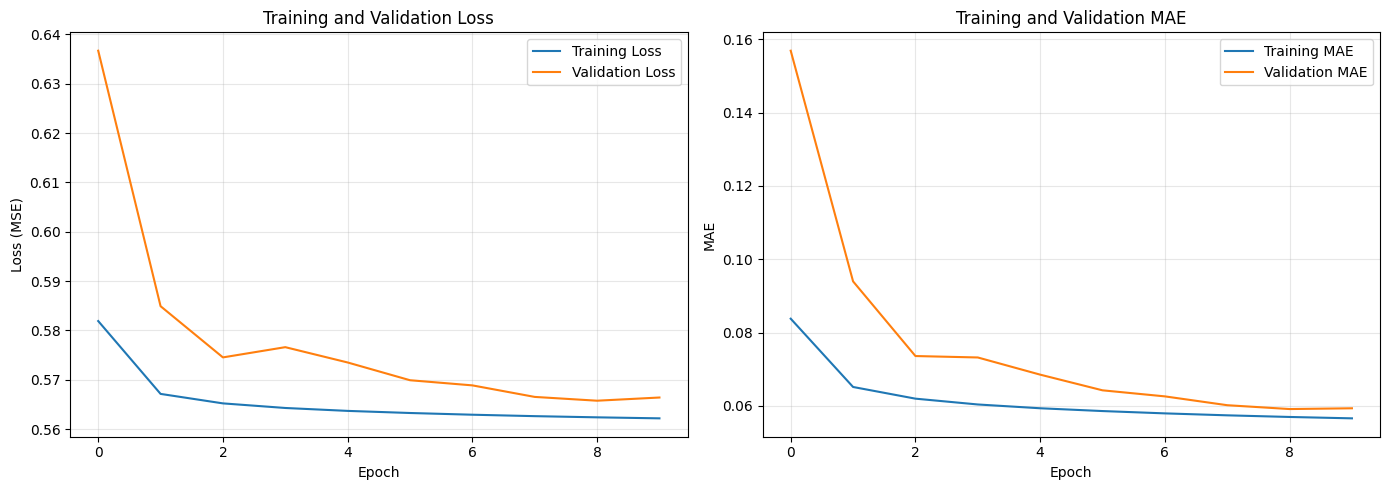

In [ ]:
# 7. PLOT TRAINING HISTORY
def plot_history(history):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss (MSE)')
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epoch'); plt.ylabel('MAE')
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.title('Training and Validation MAE')
    plt.tight_layout()
    plt.show()

plot_history(history)


Generating denoised images...
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step


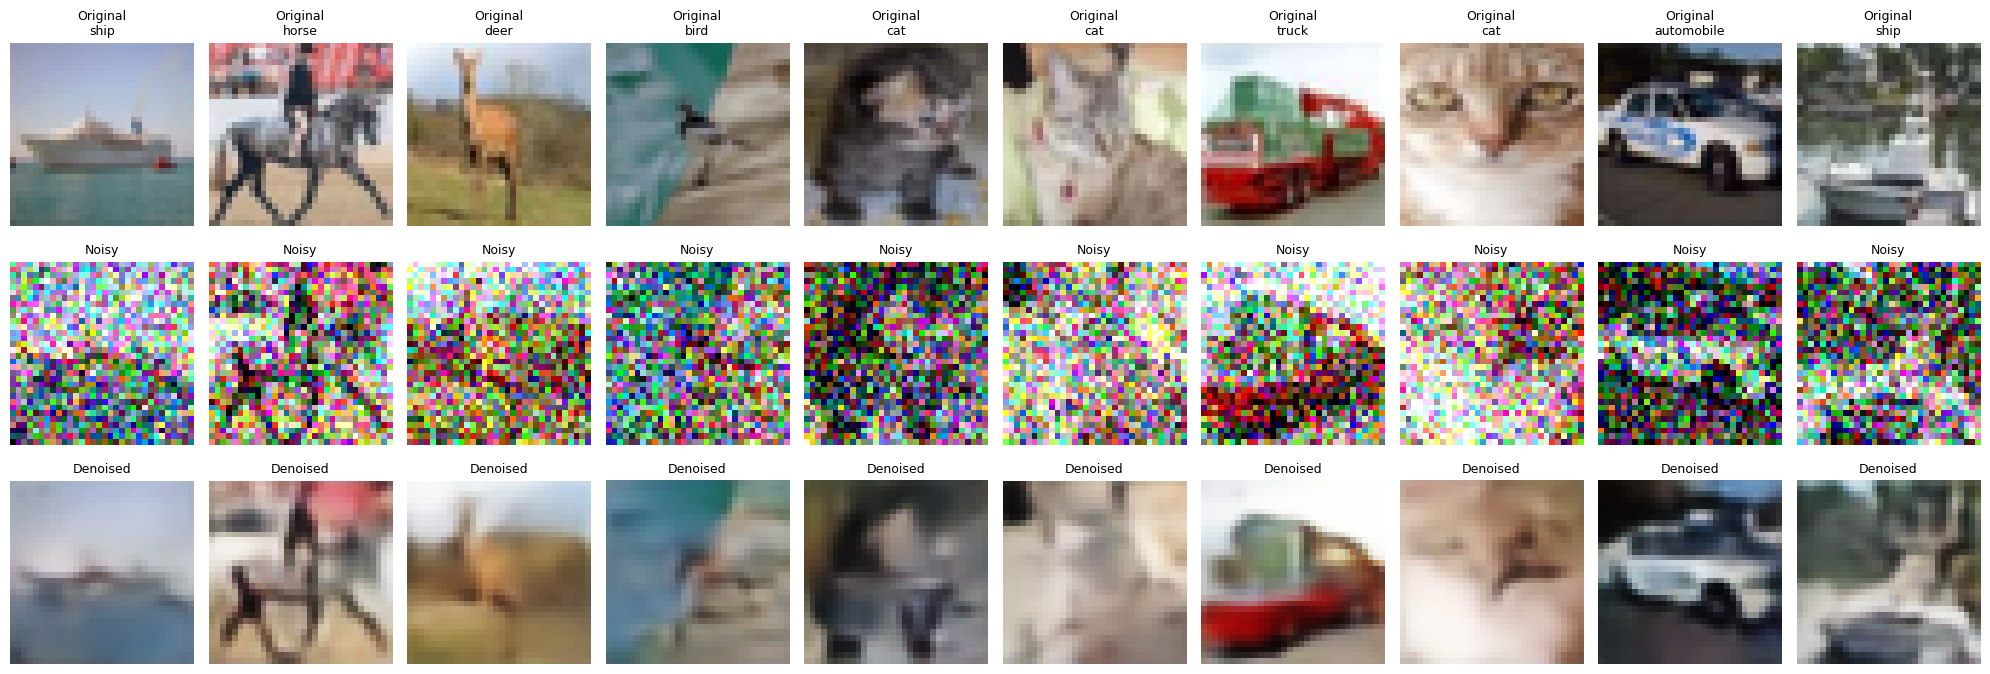

In [ ]:
# 8. EVALUATE MODEL - DENOISED OUTPUTS
print("Generating denoised images...")
denoised_images = autoencoder.predict(x_test_noisy, batch_size=128, verbose=1)

def visualize_results(clean, noisy, denoised, labels, n=10):
    plt.figure(figsize=(20, 7))
    indices = np.random.choice(len(clean), n, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(3, n, i + 1); plt.imshow(clean[idx])
        plt.title(f"Original\n{class_names[labels[idx][0]]}", fontsize=9)
        plt.axis('off')
        plt.subplot(3, n, i + 1 + n); plt.imshow(noisy[idx])
        plt.title("Noisy", fontsize=9); plt.axis('off')
        plt.subplot(3, n, i + 1 + 2*n); plt.imshow(np.clip(denoised[idx], 0, 1))
        plt.title("Denoised", fontsize=9); plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_results(x_test, x_test_noisy, denoised_images, y_test, n=10)


In [ ]:
# 9. QUANTITATIVE EVALUATION - PSNR AND SSIM
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def calculate_metrics(clean, denoised):
    psnr_values, ssim_values = [], []
    for i in range(len(clean)):
        psnr_values.append(psnr(clean[i], denoised[i], data_range=1.0))
        ssim_values.append(ssim(clean[i], denoised[i], data_range=1.0, channel_axis=2))
    return np.array(psnr_values), np.array(ssim_values)

print("Calculating metrics...")
psnr_noisy, ssim_noisy = calculate_metrics(x_test, x_test_noisy)
psnr_denoised, ssim_denoised = calculate_metrics(x_test, denoised_images)

print("\n" + "="*60)
print("QUANTITATIVE EVALUATION RESULTS")
print("="*60)
print(f"\nNoisy Images:\n  Average PSNR: {np.mean(psnr_noisy):.2f} dB\n  Average SSIM: {np.mean(ssim_noisy):.4f}")
print(f"\nDenoised Images:\n  Average PSNR: {np.mean(psnr_denoised):.2f} dB\n  Average SSIM: {np.mean(ssim_denoised):.4f}")
print(f"\nImprovement:\n  PSNR Gain: {np.mean(psnr_denoised) - np.mean(psnr_noisy):.2f} dB\n  SSIM Gain: {np.mean(ssim_denoised) - np.mean(ssim_noisy):.4f}")
print("="*60 + "\n")


Calculating metrics...

QUANTITATIVE EVALUATION RESULTS

Noisy Images:
  Average PSNR: 11.93 dB
  Average SSIM: 0.2940

Denoised Images:
  Average PSNR: 22.19 dB
  Average SSIM: 0.7438

Improvement:
  PSNR Gain: 10.25 dB
  SSIM Gain: 0.4498



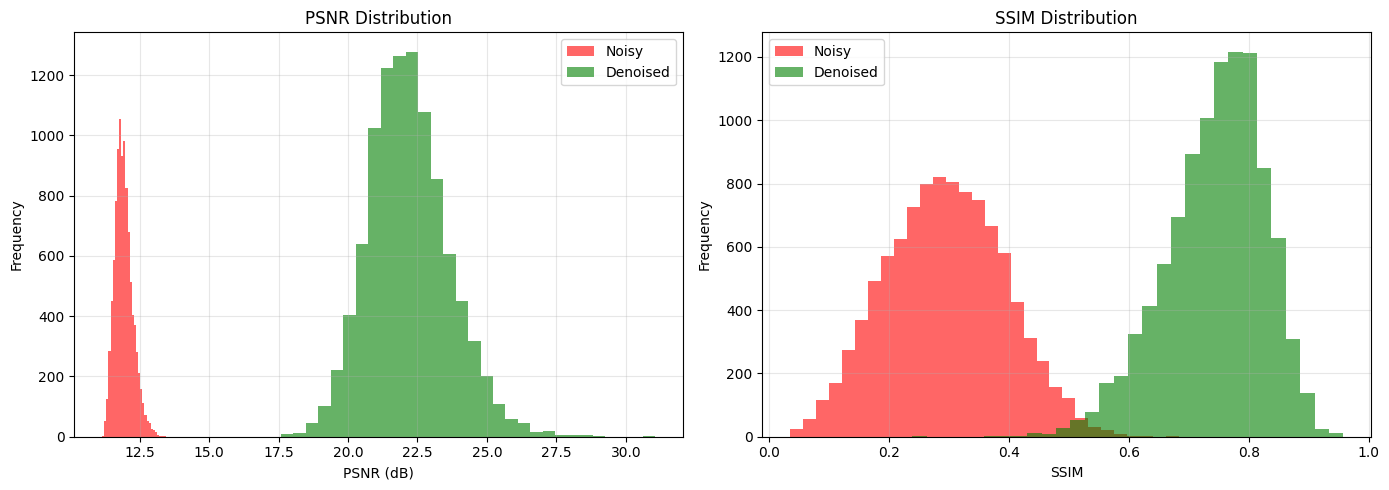

In [ ]:
# 10. PLOT METRICS DISTRIBUTION
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.hist(psnr_noisy, bins=30, alpha=0.6, label='Noisy', color='red')
plt.hist(psnr_denoised, bins=30, alpha=0.6, label='Denoised', color='green')
plt.xlabel('PSNR (dB)'); plt.ylabel('Frequency'); plt.legend()
plt.title('PSNR Distribution'); plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(ssim_noisy, bins=30, alpha=0.6, label='Noisy', color='red')
plt.hist(ssim_denoised, bins=30, alpha=0.6, label='Denoised', color='green')
plt.xlabel('SSIM'); plt.ylabel('Frequency'); plt.legend()
plt.title('SSIM Distribution'); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# 11. SAVE MODEL
autoencoder.save('denoising_autoencoder_cifar10.keras')
print("Model saved as 'denoising_autoencoder_cifar10.keras'")


Model saved as 'denoising_autoencoder_cifar10.keras'


## Comparative Analysis and Conclusion

Both autoencoders successfully removed Gaussian noise and reconstructed clean images, with performance varying by dataset complexity.

- **MNIST:** Achieved higher PSNR and SSIM due to simple grayscale patterns and uniform shapes.  
- **CIFAR-10:** Displayed slightly lower absolute metrics because of color and texture diversity, but showed similar relative improvements from noisy to denoised states.  
- **PSNR distributions** shifted rightward and **SSIM values** rose to ≈ 0.8 – 0.9, indicating effective noise suppression and detail preservation.  
- Batch Normalization in Model 2 enhanced training stability on complex RGB data.

Overall, the MNIST model demonstrated precision on simpler inputs, while the CIFAR-10 model proved the architecture’s robustness for color-image restoration. Together, they highlight the adaptability of convolutional autoencoders for real-world denoising tasks.
